# Предсказание коэффициента восстановления золота из золотосодержащей руды

**Описание данных**

*Технологический процесс*
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов*
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

Функционал качества - sMAPE (см. рисунок).

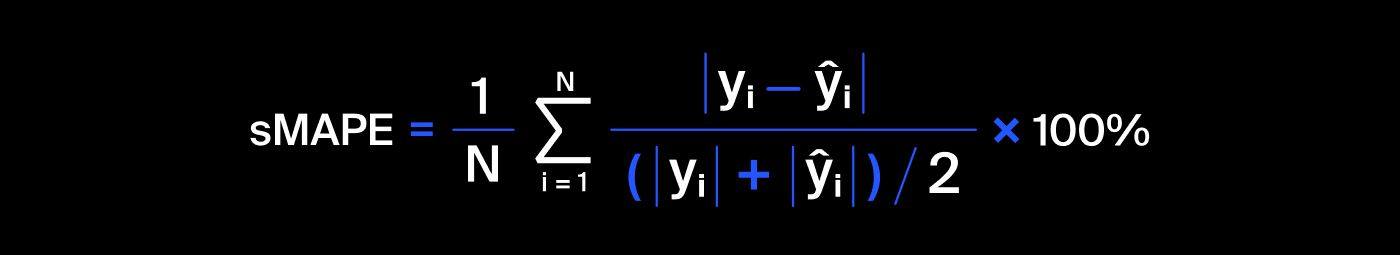

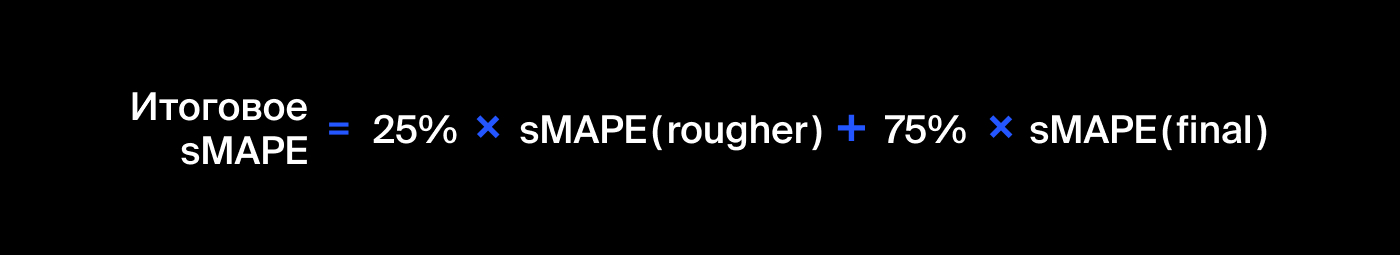

Чтобы достичь поставленно цели, необходимо выполнить следующие шаги:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# 1. Подготовка данных

## 1.1. Загрузка и сводная информация о данных

Импортируем необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
import random
import warnings
warnings.filterwarnings('ignore')

Загрузим данные.

In [3]:
train = pd.read_csv('gold_recovery_train.csv')
test = pd.read_csv('gold_recovery_test.csv')
full = pd.read_csv('gold_recovery_full.csv')

train.name = 'gold_recovery_train'   
test.name = 'gold_recovery_test'
full.name = 'gold_recovery_full'

dfs = [train, test, full]

Посмотрим первые 2 строки и сводную информацию для каждого датафрейма.

In [4]:

for df in dfs:
    print('                           ' + df.name + '                           ')
    print('\n')
    display(df.info())
    display(df.head(2))
    print('Кол-во строк: {}\nКол-во столбцов: {}'.format(df.shape[0], df.shape[1]))
    print('\n')
    print('-------------------------------------------------------------------------')

                           gold_recovery_train                           


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


Кол-во строк: 16860
Кол-во столбцов: 87


-------------------------------------------------------------------------
                           gold_recovery_test                           


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air  

None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


Кол-во строк: 5856
Кол-во столбцов: 53


-------------------------------------------------------------------------
                           gold_recovery_full                           


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                            

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


Кол-во строк: 22716
Кол-во столбцов: 87


-------------------------------------------------------------------------


Все столбцы датафреймов содержат корректные типы данных, кроме столбца `date`. Приведем его к типу данных `datetime64` и проверим результат исправления.

In [5]:
for df in dfs:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    name = df.name
    df.sort_values(by='date', inplace=True)
    df.name = name
    print('Тип данных столбца "date" у датафрейма "{}": {}'.format(df.name, df.dtypes['date']))

Тип данных столбца "date" у датафрейма "gold_recovery_train": datetime64[ns]
Тип данных столбца "date" у датафрейма "gold_recovery_test": datetime64[ns]
Тип данных столбца "date" у датафрейма "gold_recovery_full": datetime64[ns]


Дополнительно проверим наличие дублей в датафреймах. Будем считать строки задублированными, если у них одинаковые значения в столбце `date`.

In [6]:
for df in dfs:
    print('Кол-во дублей в датафрейме "{}": {} шт.'.format(df.name, len(train[train.duplicated('date')])))

Кол-во дублей в датафрейме "gold_recovery_train": 0 шт.
Кол-во дублей в датафрейме "gold_recovery_test": 0 шт.
Кол-во дублей в датафрейме "gold_recovery_full": 0 шт.


Все строки у всех датафреймов уникальны. Установим столбец `date` в качестве индекса для всех датафреймов.

In [7]:
for df in dfs:
    name = df.name
    df.set_index(keys='date', inplace=True)
    df.name = name

Дополнительно определим переменные `targets` и `features`, в которых содержатся целевые и нецелевые признаки, соответственно.

In [8]:
targets = ['rougher.output.recovery', 'final.output.recovery']
features = [column for column in full.columns if column not in ['rougher.output.recovery', 'final.output.recovery']]

Все столбцы датафреймов содержат корректные типы данных.

## 1.2. Предобработка данных

Найдем столбцы, которые содержат пропуски, по каждому датафрейму. Напишем для этого специальную функцию.

In [9]:
def pivot_table_nan_values(df):
    print('Датафрейм {}'.format(df.name))
    nan_counts = df.isna().sum().loc[df.isna().sum() > 0].sort_values(ascending=False)
    nan_counts = pd.DataFrame(data=nan_counts, columns=['Кол-во пропусков, шт.'])
    nan_counts.index.name = 'Признак'
    display(nan_counts)
    print('-----------------------------------------------------------')
    print('\n')

In [10]:
for df in dfs:
    pivot_table_nan_values(df)

Датафрейм gold_recovery_train


,"Кол-во пропусков, шт."
Признак,
rougher.output.recovery,2573
rougher.output.tail_ag,2250
rougher.output.tail_au,2249
rougher.output.tail_sol,2249
secondary_cleaner.output.tail_sol,1986
...,...
primary_cleaner.state.floatbank8_b_level,27
primary_cleaner.state.floatbank8_d_level,27
primary_cleaner.state.floatbank8_c_level,27


-----------------------------------------------------------


Датафрейм gold_recovery_test


,"Кол-во пропусков, шт."
Признак,
rougher.input.floatbank11_xanthate,353
primary_cleaner.input.sulfate,302
primary_cleaner.input.depressant,284
rougher.input.floatbank10_sulfate,257
primary_cleaner.input.xanthate,166
rougher.input.floatbank10_xanthate,123
rougher.input.feed_sol,67
rougher.input.floatbank11_sulfate,55
rougher.input.feed_rate,40


-----------------------------------------------------------


Датафрейм gold_recovery_full


,"Кол-во пропусков, шт."
Признак,
rougher.output.recovery,3119
rougher.output.tail_ag,2737
rougher.output.tail_sol,2736
rougher.output.tail_au,2736
rougher.input.floatbank11_xanthate,2257
...,...
rougher.calculation.sulfate_to_au_concentrate,44
rougher.calculation.floatbank10_sulfate_to_au_feed,44
primary_cleaner.state.floatbank8_d_level,43


-----------------------------------------------------------




У каждого датафрейма содержатся значительное число признаков с пропусками. Для начала предобработаем нецелевые признаки (`features`).

Данные индексируются датой и временем получения информации (`date`). Соседние по времени параметры часто похожи. Обработаем пропуски с помощью метода `.fillna(method='ffill')`.

In [11]:
for df in dfs:
    name = df.name
    features = [column for column in df.columns if column not in targets]
    df[features] = df[features].fillna(method='ffill', axis=0)
    df.name = name
    
    pivot_table_nan_values(df)

Датафрейм gold_recovery_train


,"Кол-во пропусков, шт."
Признак,
rougher.output.recovery,2573
final.output.recovery,1521


-----------------------------------------------------------


Датафрейм gold_recovery_test


,"Кол-во пропусков, шт."
Признак,


-----------------------------------------------------------


Датафрейм gold_recovery_full


,"Кол-во пропусков, шт."
Признак,
rougher.output.recovery,3119
final.output.recovery,1963


-----------------------------------------------------------




После использования метода `.fillna(method='ffill')` все пропуски в нецелевых признаках (`features`) были заполнены. Можно также обнаружить, что тестовая выборка (`test`) не содержит целевые признаки (`rougher.output.recovery` и `rougher.output.recovery`).

Проверим количество пропусков в целевых признаках (`targets`). Напишем для этого специальную функцию.

In [12]:
def nan_column_counts(data, column):
    nan_counts = len(data.loc[data[column].isnull(), column])
    print('Кол-во пропусков в столбце "{}" в датафрейме "{}": {}'.format(column, data.name, nan_counts))

В тестовой выборке отсутствуют целевые признаки (`rougher.output.recovery` и `rougher.output.recovery`). В следующем шаге добавим таргеты к тестовой выборке из датафрейма `full` с помощью метода `.join()`.

На данном этапе проверим количество пропусков в целевых признаках только у датафреймов `train` и `full`.

In [13]:
for df in [train, full]:
    for column in targets:
        nan_column_counts(df, column)

Кол-во пропусков в столбце "rougher.output.recovery" в датафрейме "gold_recovery_train": 2573
Кол-во пропусков в столбце "final.output.recovery" в датафрейме "gold_recovery_train": 1521
Кол-во пропусков в столбце "rougher.output.recovery" в датафрейме "gold_recovery_full": 3119
Кол-во пропусков в столбце "final.output.recovery" в датафрейме "gold_recovery_full": 1963


Датафреймы `train` и `full` содержат значительное число пропусков в целевых признаках (`targets`). Пропуски в таргетах лучше удалить, т.к. мы их предсказываем.

In [14]:
for df in [train, full]:
    name = df.name
    df.dropna(subset=targets, how='any', axis=0, inplace=True)
    df.name = name
    
    #Проверим результат удаления
    print('                            Датафрейм "{}"'.format(df.name))
    for column in targets:
        nan_column_counts(df, column)
    print('\n')

dfs = [train, test, full]

                            Датафрейм "gold_recovery_train"
Кол-во пропусков в столбце "rougher.output.recovery" в датафрейме "gold_recovery_train": 0
Кол-во пропусков в столбце "final.output.recovery" в датафрейме "gold_recovery_train": 0


                            Датафрейм "gold_recovery_full"
Кол-во пропусков в столбце "rougher.output.recovery" в датафрейме "gold_recovery_full": 0
Кол-во пропусков в столбце "final.output.recovery" в датафрейме "gold_recovery_full": 0




После предобработки данных датафреймы больше не содержат пропуски.

## 1.3. Проверка правильности расчета признака эффективность обогащения

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`.

Найдем среднюю абсолютную ошибку (MAE) и коэффициент детерминации (R2) между расчётами и значениями признака `rougher.output.recovery`.

In [15]:
C = train['rougher.output.concentrate_au'] #доля золота в концентрате после флотации/очистки;
F = train['rougher.input.feed_au'] #доля золота в сырье/концентрате до флотации/очистки;
T =train['rougher.output.tail_au'] #доля золота в отвальных хвостах после флотации/очистки.

train['rougher.output.recovery_check'] = ( (C*(F - T)) / (F*(C - T)) ) * 100 #создадим столбец для проверик `rougher.output.recovery`
mae_recovery_train = mean_absolute_error(train['rougher.output.recovery'], train['rougher.output.recovery_check'])
r2 = r2_score(train['rougher.output.recovery'], train['rougher.output.recovery_check']) 
print('Средняя абсолютная ошибка (MAE) признака "rougher.output.recovery": {:.4f}'.format(mae_recovery_train))
print('Коэффициент детерминации (R2) признака "rougher.output.recovery": {:.2%}'.format(r2))

#Удалим созданный столбец "rougher.output.recovery_check" за ненадобностью
train.drop('rougher.output.recovery_check', axis=1, inplace=True)

Средняя абсолютная ошибка (MAE) признака "rougher.output.recovery": 0.0000
Коэффициент детерминации (R2) признака "rougher.output.recovery": 100.00%


Действительно, эффективность обогащения рассчитана верно.

## 1.4. Анализ признаков, недоступных в тестовой выборке

По условию задачи в тестовом наборе нет целевых признаков. Приджойним целевые признаки (`rougher.output.recovery` и `final.output.recovery`) к тестовой выборке из датафрейма `full`.

In [16]:
test_name = test.name
test = test.join(full[targets], how='left')
test.name = test_name

Проанализируем признаки недоступные в тестовой выборке и, к какому типу данных они относятся. Создадим для этого специальную функцию.

In [17]:
def df1_columns_not_in_df2(df1, df2):
    count = 0
    omitted_columns = []
    for column in df1.columns:
        if column not in df2.columns: 
            omitted_columns.append(column)
            count +=1
    count_of_omitted_columns = "Кол-во недоступных столбцов в тестовой выборке: {}".format(count)
    return (omitted_columns, count_of_omitted_columns)

In [18]:
#Найдем наименования столбцов, которые есть в обучающей выборке, но нет в тестовой
df1_columns_not_in_df2(train, test)

(['final.output.concentrate_ag',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.concentrate_au',
  'final.output.tail_ag',
  'final.output.tail_pb',
  'final.output.tail_sol',
  'final.output.tail_au',
  'primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.tail_ag',
  'primary_cleaner.output.tail_pb',
  'primary_cleaner.output.tail_sol',
  'primary_cleaner.output.tail_au',
  'rougher.calculation.sulfate_to_au_concentrate',
  'rougher.calculation.floatbank10_sulfate_to_au_feed',
  'rougher.calculation.floatbank11_sulfate_to_au_feed',
  'rougher.calculation.au_pb_ratio',
  'rougher.output.concentrate_ag',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol',
  'rougher.output.concentrate_au',
  'rougher.output.tail_ag',
  'rougher.output.tail_pb',
  'rougher.output.tail_sol',
  'rougher.output.

В тестовой выборке не хватает 32 столбца, у всех которых тип данных - `float64`. Данные параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Для того, чтобы обучить модель, необходимо, чтобы количество признаков (`features`) в тестовой выборке совпадало с количеством признаков (`features`) в обучающей. В `Шаге 3` удалим те признаки из обучающей выборки, которых нет в тестовой.

После приджойнивания столбцов у тестовой выборки (`test`) могли появиться строки с пустыми значениями. Проверим еще раз тестовую выборку на наличие пропусков.

In [19]:
pivot_table_nan_values(test)

Датафрейм gold_recovery_test


,"Кол-во пропусков, шт."
Признак,
final.output.recovery,566
rougher.output.recovery,566


-----------------------------------------------------------




Удалим строки в тестовой выборке, содержащие пропуски, и проверим результат.

In [20]:
test.dropna(axis=0, inplace=True)
dfs = [train, test, full]

pivot_table_nan_values(test)

Датафрейм gold_recovery_test


,"Кол-во пропусков, шт."
Признак,


-----------------------------------------------------------




### Вывод

В ходе данного шага была частичная предобработка данных. Дальнейшие шаги по предобработке, а именно стандартизация количественных признаков, будет проведена в `Шаге 3`.

Также была проведена проверка корректности расчета эффективности обогащения, в ходе которой выяснилось, что показатель рассчитан верно.

# 2. Анализ данных

### 2.1. Динамика концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Проанализируем, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

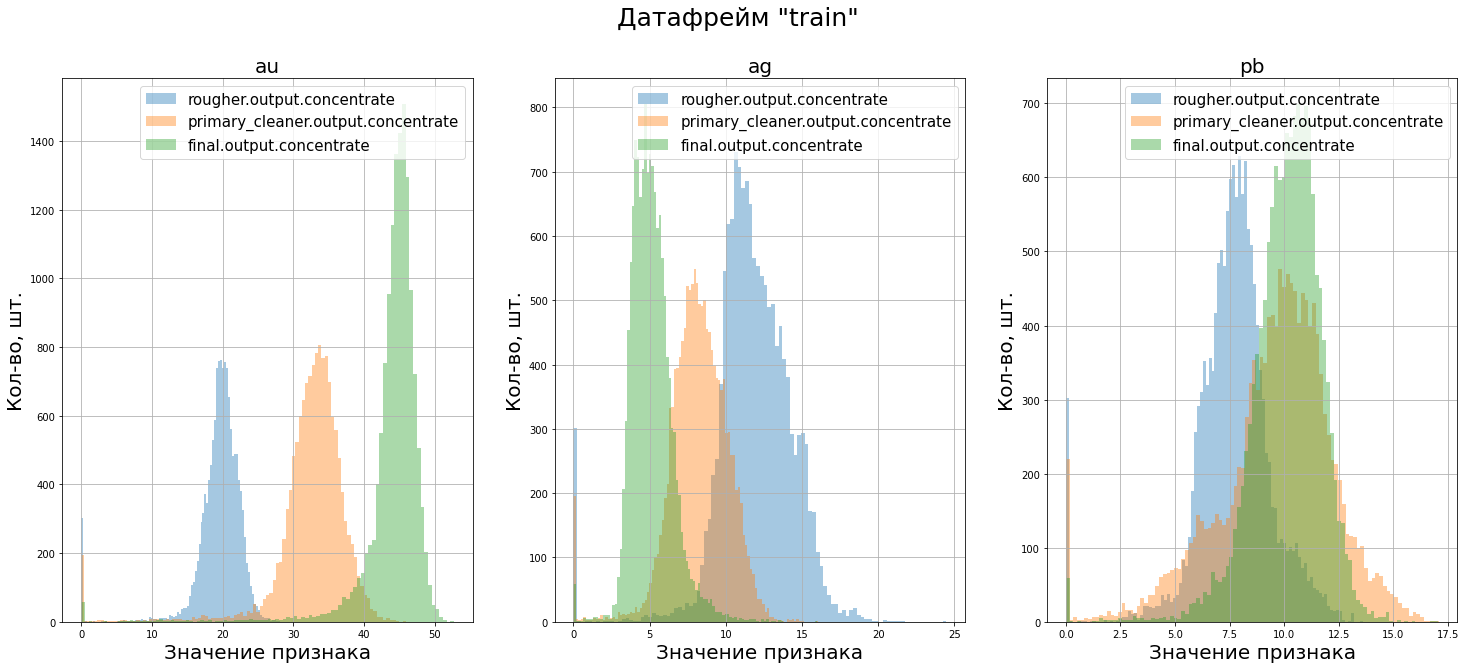

In [21]:
metals = ['au', 'ag', 'pb']
stages = ['rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

fig = plt.figure(figsize=(25, 10))
fig.suptitle('Датафрейм "train"',  fontsize=25)


rows = 1
cols = 3
counter = 1
for metal in metals:
    ax = plt.subplot(rows, cols, counter)
    plt.xlabel('Значение признака', fontsize=20)
    plt.ylabel('Кол-во, шт.', fontsize=20)
    ax.set_title(metal, fontsize=20)
    for stage in stages:
        train[stage + '_' + metal].hist(bins=100, alpha=0.4, label=(stage))
    plt.legend(loc='upper right', fontsize=15)
    counter += 1
plt.show()

### Вывод

Динамика концентрации металлов (`Au`, `Ag`, `Pb`) следующая:
* С каждой последующим этапом отчистки концентрация золота (`Au`) значительно увеличивается;
* Концентрация серебра (`Ag`), в отличие от золота, наоборот снижается с каждым этапом;
* Концетрация свинца (`Pb`) увеличивается с каждым этапом, но не значительно.

### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

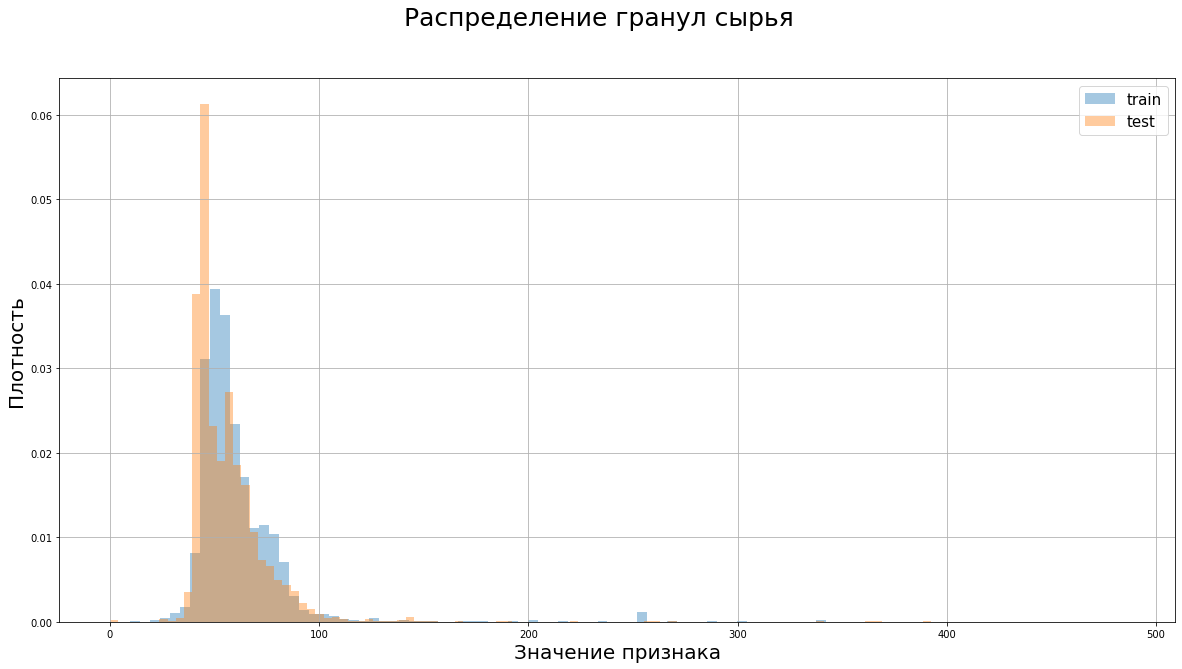

In [22]:
train_test = [train, test]

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Распределение гранул сырья',  fontsize=25)

plt.xlabel('Значение признака', fontsize=20)
plt.ylabel('Плотность', fontsize=20)
train['rougher.input.feed_size'].hist(bins=100, density=True, alpha=0.4, label='train')
test['rougher.input.feed_size'].hist(bins=100, density=True, alpha=0.4, label='test')
plt.legend(loc='upper right', fontsize=15)
plt.show()

### Вывод

Размеры гранул сырья на обучающей и тестовой выборках не сильно отличаются друг от друга.

### 2.3.  Исследуем суммарную концентрацию всех веществ на разных стадиях

Создадим дополнительные столбцы `_total_metals_concentrate` для каждого этапа обработки для датафреймов `full` и `train`.

In [23]:
for df in [full, train]:
    for stage in stages:
        df[(stage + '_total_metals')] = (
            df[stage + '_au'] + df[stage + '_ag'] + 
            df[stage + '_pb'] + df[stage + '_sol'])

Построим гистограмму распределения.

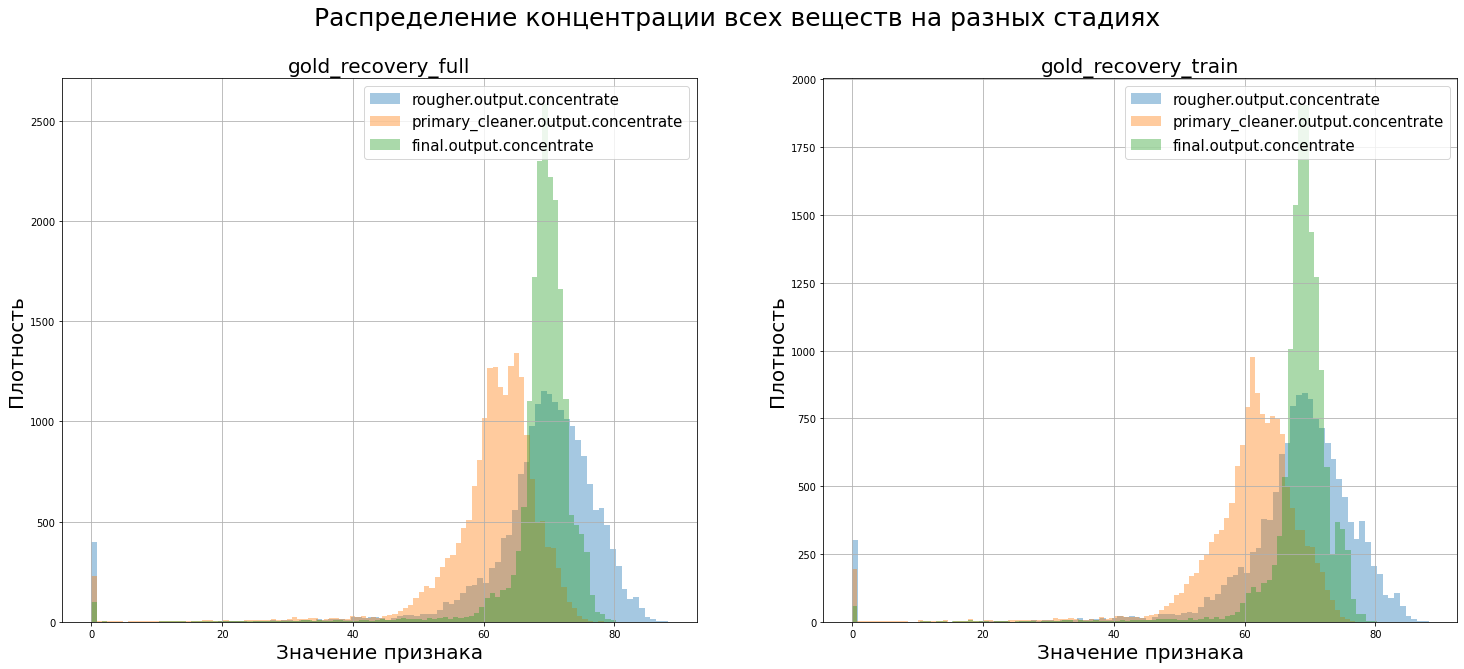

In [24]:
fig = plt.figure(figsize=(25, 10))
fig.suptitle('Распределение концентрации всех веществ на разных стадиях',  fontsize=25)

rows = 1
cols = 2
counter = 1
for df in [full, train]:
    ax = plt.subplot(rows, cols, counter)
    ax.set_title(df.name, fontsize=20)    
    plt.xlabel('Значение признака', fontsize=20)
    plt.ylabel('Плотность', fontsize=20)
    for stage in stages:
        df[stage + '_total_metals'].hist(bins=100, alpha=0.4, label=(stage))
    plt.legend(loc='upper right', fontsize=15)
    counter += 1
plt.show()

У датафреймов `full` и `train` имеются аномальные значения близкие к нулю (будем считать меньше 5). Удалим строки из датафреймов `full` и `train`, у которых на какой-либо стадии концентрация всех металлов меньше 5.

In [25]:
for df in [full, train]:
    df.drop(df[((
        df['rougher.output.concentrate_total_metals'] < 5) | (df['primary_cleaner.output.concentrate_total_metals'] < 5) |
    (df['final.output.concentrate_total_metals'] < 5))].index, inplace=True)

Удалим столбцы с общей концентрацией всех металлов на всех этапов за дальнейшей ненадобностью. 

In [26]:
for df in [full, train]:
        df.drop(['rougher.output.concentrate_total_metals',
                 'primary_cleaner.output.concentrate_total_metals',
                 'final.output.concentrate_total_metals'], axis=1, inplace=True)


### Вывод

В полной и обучающей выборках находилось значительное количество признаков с общей концентрацией металлов ниже 5. Данная аномалия могла повлиять на качество обучения моделей в последующих шагах, в следствие чего было принято решение удалить строки, содержащие данные аномалии.

# 3. Модель

Как было указано в `Шаге 1`, перед началом обучения моделей удалим те признаки из обучающей выборки, которых нет в тестовой.

In [27]:
train.drop(df1_columns_not_in_df2(train, test)[0], axis=1, inplace=True)
dfs = [train, test, full]

#Проверим результат
df1_columns_not_in_df2(train, test)[1]

'Кол-во недоступных столбцов в тестовой выборке: 0'

Теперь обучающая и тестовая выборки содержит одинаковые столбцы.

Разделим обучающую и тестовую выборки на `features` (целевые признаки), `target_rougher` (признак `rougher.output.recovery`) и `target_final` (признак `final.output.recovery`). 

In [28]:
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = pd.Series(train['rougher.output.recovery'])
target_train_final = pd.Series(train['final.output.recovery'])

features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = pd.Series(test['rougher.output.recovery'])
target_test_final = pd.Series(test['final.output.recovery'])


### 3.1. Обучение модели на предсказание признака `rougher.output,recovery`

Для решения задачи введём новую метрику качества — `sMAPE`. Напишем функцию `sMAPE`, исходя из условия задачи.

In [29]:
def sMAPE(y_true, y_pred, **kwargs):
    score = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return score

#### 3.1.1. Модель решающего дерева (`DecisionTreeRegressor`) 

В качестве алгоритма предсказания целевого признака выберем модель решающего дерева (`DecisionTreeRegressor`). Для начала необходимо произвести стандартизацию данных. Реализуем это с помощью контейнера `Pipeline()`, в котором последовательно стандартизируются данные, а затем предсказывается целевой признак на обработанных данных.

Создадим функцию, которая будет проделывать описанные выше шаги. Кросс-валидация будет заложена в `GridSearch` с помощью параметра `cv=4` внутри функции. В дальнейшем это облегчит обучение других моделей.

In [30]:
def tuned_model_regression(model, parameters, name_of_regressor):
    #Создадим экземпляры класса стандартизатора и классификатора
    scaler = StandardScaler()
    
    #Далее создаём массив последовательности «шагов» конвейера
    steps = [('normalizer', scaler), (name_of_regressor, model)]
    pipe = Pipeline(steps)
    
    #Создаем множество гипермараметров для решающего дерева
    params = parameters

    smape_scorer = make_scorer(sMAPE, greater_is_better=False)

    #Укажем внутри `GridSearch` параметр кросс-валидации `cv` 
    grid_search = GridSearchCV(estimator=pipe, param_grid=params, scoring=smape_scorer, cv=4)
    return grid_search

Проверим качество обученной модели на тестовой выборке.

In [31]:
rougher_tree = tuned_model_regression(
    model=DecisionTreeRegressor(random_state=12345),
    parameters={'rougher_tree__max_depth': np.arange(1, 21),
               'rougher_tree__min_samples_leaf': [1, 5, 10, 20, 50, 100]},
    name_of_regressor='rougher_tree')

rougher_tree.fit(features_train, target_train_rougher)
predicted_test_rougher_tree = rougher_tree.predict(features_test)

sMAPE_rougher_tree = sMAPE(target_test_rougher, predicted_test_rougher_tree)

In [32]:
print('Значение метрики sMAPE для предсказания "rougher.output.recovery": {:.2f}%'.format(sMAPE_rougher_tree))

Значение метрики sMAPE для предсказания "rougher.output.recovery": 8.28%


#### 3.1.2. Модель линейной регрессии (`LinearRegression`) 

Обучим модель с помощью линейной регрессии. Аналогично предыдущему пункту сначала произведем стандартизацию данных, а затем обучим модель с помощью функции `tuned_model_regression()`.

In [33]:
rougher_linear = tuned_model_regression(
    model=LinearRegression(),
    parameters={'rougher_linear__fit_intercept': [True, False],
                'rougher_linear__copy_X': [True, False]
               },
    name_of_regressor='rougher_linear')

rougher_linear.fit(features_train, target_train_rougher)
predicted_test_rougher_linear = rougher_linear.predict(features_test)

sMAPE_rougher_linear = sMAPE(target_test_rougher, predicted_test_rougher_linear)

In [34]:
print('Значение метрики sMAPE для предсказания "rougher.output.recovery": {:.2f}%'.format(sMAPE_rougher_linear))

Значение метрики sMAPE для предсказания "rougher.output.recovery": 8.57%


#### 3.1.3. Проверка адекватности регрессионных моделей

Проверим модели на адекватность с помощью функции `DummyRegressor()`.

In [35]:
rougher_dummy = DummyRegressor(strategy='median')

rougher_dummy.fit(features_train, target_train_rougher)
predicted_test_rougher_dummy = rougher_dummy.predict(features_test)

sMAPE_rougher_dummy = sMAPE(target_test_rougher, predicted_test_rougher_dummy)

print('Значение метрики sMAPE для предсказания "rougher.output.recovery": {:.2f}%'.format(sMAPE_rougher_dummy))

Значение метрики sMAPE для предсказания "rougher.output.recovery": 8.53%


Модель, обученная с помощью решающего дерева, показала результат чуть лучше, чем модель, которая просто присваивает каждому объекту тестовой выборки медианное значение целевого признака. Модель, обученная с помощью линейной регрессии, и вовсе хуже прогнозирует целевой признак, чем медиана.

Выберем наилучшую модель, предсказывающую `rougher.output.recovery`, - модель, обученную с помощью решающего дерева.

In [36]:
best_rougher_model = rougher_tree
best_rougher_smape = sMAPE_rougher_tree

### Вывод 

Модель, обученная с помошью линейной регресси хуже предсказывает целевой признак `rougher.output.recovery`, чем решающее дерево. Для подсчета итогового `sMAPE_total` в дальнейшем, будем использовать модель предсказания `rougher.output.recovery`, обученную с помощью решающего дерева.

### 3.2. Обучение модели на предсказание признака `final.output,recovery`

#### 3.2.1. Модель решающего дерева (`DecisionTreeRegressor`)¶

Обучим модель с помощью решающего дерева. Аналогично предыдущим пунктам сначала произведем стандартизацию данных, а затем обучим модель с помощью функции `tuned_model_regression()`.

In [37]:
final_tree = tuned_model_regression(
    model=DecisionTreeRegressor(random_state=12345),
    parameters={'final_tree__max_depth': np.arange(1, 21),
               'final_tree__min_samples_leaf': [1, 5, 10, 20, 50, 100]},
    name_of_regressor='final_tree')

final_tree.fit(features_train, target_train_final)
predicted_test_final_tree = final_tree.predict(features_test)

sMAPE_final_tree = sMAPE(target_test_final, predicted_test_final_tree)

In [38]:
print('Значение метрики sMAPE для предсказания "final.output.recovery": {:.2f}%'.format(sMAPE_final_tree))

Значение метрики sMAPE для предсказания "final.output.recovery": 9.33%


#### 3.2.2. Модель линейной регрессии (`LinearRegression`) 

Обучим модель с помощью линейной регрессии. Аналогично предыдущим пунктам сначала произведем стандартизацию данных, а затем обучим модель с помощью функции `tuned_model_regression()`.

In [39]:
final_linear = tuned_model_regression(
    model=LinearRegression(),
    parameters={'final_linear__fit_intercept': [True, False],
                'final_linear__copy_X': [True, False]
               },
    name_of_regressor='final_linear')

final_linear.fit(features_train, target_train_final)
predicted_test_final_linear = final_linear.predict(features_test)

sMAPE_final_linear = sMAPE(target_test_final, predicted_test_final_linear)

In [40]:
print('Значение метрики sMAPE для предсказания "final.output.recovery": {:.2f}%'.format(sMAPE_final_linear))

Значение метрики sMAPE для предсказания "final.output.recovery": 9.60%


#### 3.2.3. Проверка адекватности регрессионных моделей

Проверим модели на адекватность с помощью функции `DummyRegressor()`.

In [41]:
final_dummy = DummyRegressor(strategy='median')

final_dummy.fit(features_train, target_train_final)
predicted_test_final_dummy = final_dummy.predict(features_test)

sMAPE_final_dummy = sMAPE(target_test_final, predicted_test_final_dummy)

print('Значение метрики sMAPE для предсказания "rougher.output.recovery": {:.2f}%'.format(sMAPE_final_dummy))

Значение метрики sMAPE для предсказания "rougher.output.recovery": 9.76%


Обе модели показали результат чуть лучше, чем модель, которая просто присваивает каждому объекту тестовой выборки медианное значение целевого признака.

Выберем наилучшую модель, предсказывающую `rougher.output.recovery`, - модель, обученную с помощью решающего дерева.

In [42]:
best_final_model = final_tree
best_final_smape = sMAPE_final_tree

### Вывод 

Как и при предсказании `rougher.output.recovery`, лучшей моделью (т.е. с наименьшим значением `sMAPE`) является модель, обученная с помощью решающего дерева. Для подсчета итогового `sMAPE_total` в дальнейшем, будем использовать модель предсказания `final.output.recovery`, обученную с помощью решающего дерева.

### 3.3. Подсчет итогового значения `sMAPE`

Итоговое `sMAPE` считается по формуле: `sMAPE_total` = 25% * `sMAPE_rougher` + 75% * `sMAPE_final`.

In [43]:
def sMAPE_total(smape_rougher, smape_final):
    total_smape = 0.25*smape_rougher + 0.75*smape_final
    return total_smape

print('Итоговое sMAPE: {:.2f}%'.format(sMAPE_total(best_rougher_smape, best_final_smape)))

Итоговое sMAPE: 9.06%


## Вывод

В ходе проделанной работы удалось обучить модель с помощью алгоритма решающего дерева и добиться итогового качества модели (`sMAPE_total`) равное 9,06%.